In [2]:
import seaborn as sns
import numpy as np 
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv("breastcancer.csv")
data.head()

,id,diag,radimean,textmean,perimean,areamean,smoothnessmean,compactnessmean,concavitymean,concavepointsmean,...,radworst,textworst,perimeterworst,areaworst,smoothnessworst,compactnessworst,concavityworst,concavepointsworst,symmworst,fractaldimensionworst
0,842302,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Text(0, 0.5, 'Frequency')

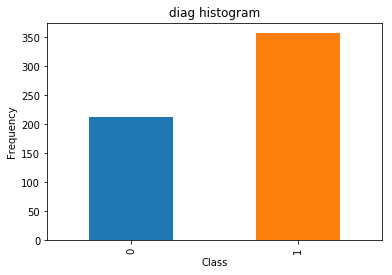

In [104]:
count_classes = pd.value_counts(data['diag'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("diag histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

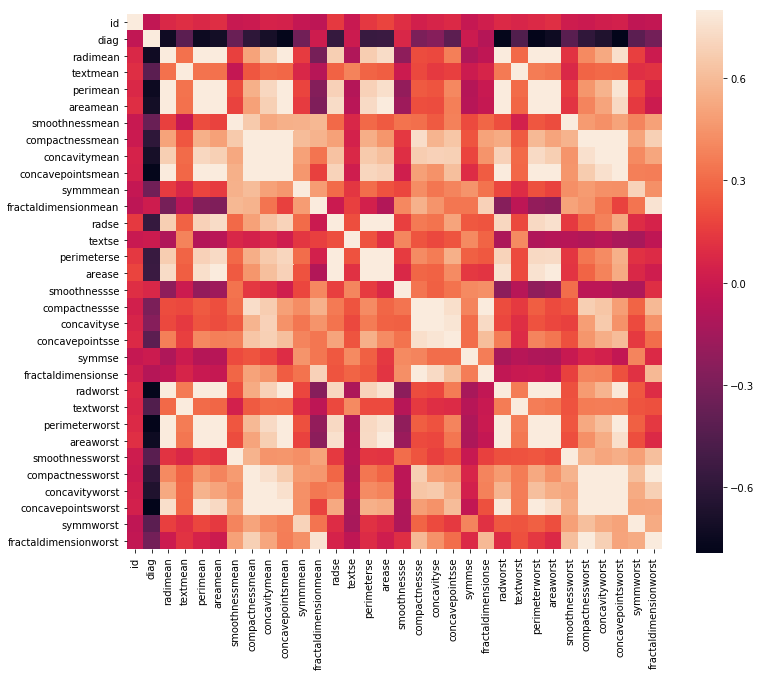

In [4]:
corrmat = data.corr()
fig = plt.figure(figsize = (12, 10))
sns.heatmap(corrmat, vmax = 0.8, square = True)
plt.show()

In [105]:
from sklearn.preprocessing import StandardScaler

In [107]:
class Autoencoder(object):

    def __init__(self, n_hidden_1, n_hidden_2, n_input, learning_rate):
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_input = n_input

        self.learning_rate = learning_rate

        self.weights, self.biases = self._initialize_weights()

        self.x = tf.placeholder("float", [None, self.n_input])

        self.encoder_op = self.encoder(self.x)
        self.decoder_op = self.decoder(self.encoder_op)

        self.cost = tf.reduce_mean(tf.pow(self.x - self.decoder_op, 2))
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.cost)

        init = tf.initialize_all_variables()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
      
        weights = {
            'encoder_h1': tf.Variable(tf.random_normal([self.n_input, self.n_hidden_1])),
            'encoder_h2': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_hidden_2])),
            'decoder_h1': tf.Variable(tf.random_normal([self.n_hidden_2, self.n_hidden_1])),
            'decoder_h2': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_input])),
        }
        biases = {
            'encoder_b1': tf.Variable(tf.random_normal([self.n_hidden_1])),
            'encoder_b2': tf.Variable(tf.random_normal([self.n_hidden_2])),
            'decoder_b1': tf.Variable(tf.random_normal([self.n_hidden_1])),
            'decoder_b2': tf.Variable(tf.random_normal([self.n_input])),
        }

        return weights, biases

    def encoder(self, X):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, self.weights['encoder_h1']),
                                       self.biases['encoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['encoder_h2']),
                                       self.biases['encoder_b2']))
        return layer_2

    def decoder(self, X):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, self.weights['decoder_h1']),
                                       self.biases['decoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['decoder_h2']),
                                       self.biases['decoder_b2']))
        return layer_2

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict={self.x: X})

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def transform(self, X):
        return self.sess.run(self.encoder_op, feed_dict={self.x: X})

    def reconstruct(self, X):
        return self.sess.run(self.decoder_op, feed_dict={self.x: X})

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
bad_data = data[data['diag'] == 0]
good_data = data[data['diag'] == 1]
#print 'bad: {}, good: {}'.format(len(bad_data), len(good_data))

In [111]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = X_train[X_train['diag']==1]
X_train = X_train.drop(['diag'], axis=1)

y_test = X_test['diag']
X_test = X_test.drop(['diag'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [112]:
X_good = good_data.ix[:, good_data.columns != 'diag']
y_good = good_data.ix[:, good_data.columns == 'diag']

X_bad = bad_data.ix[:, bad_data.columns != 'diag']
y_bad = bad_data.ix[:, bad_data.columns == 'diag']

C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Acer\Anaconda3\lib\

In [113]:
model = Autoencoder(n_hidden_1=15, n_hidden_2=3, n_input=X_train.shape[1], learning_rate = 0.01)

In [114]:
training_epochs = 100
batch_size = 256
display_step = 100
record_step = 10

In [115]:
total_batch = int(X_train.shape[0]/batch_size)

cost_summary = []

for epoch in range(training_epochs):
    cost = None
    for i in range(total_batch):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch = X_train[batch_start:batch_end, :]
        
        cost = model.partial_fit(batch)
    
    if epoch % display_step == 0 or epoch % record_step == 0:
        total_cost = model.calc_total_cost(X_train)
        
        if epoch % record_step == 0:
            cost_summary.append({'epoch': epoch+1, 'cost': total_cost})
        
        if epoch % display_step == 0:
            print("Epoch:{}, cost={:.9f}".format(epoch+1, total_cost))

Epoch:1, cost=474525099622400.000000000


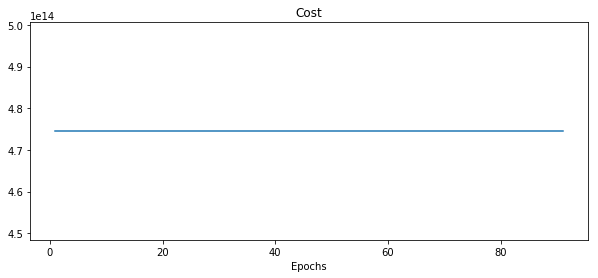

In [116]:
f, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(list(map(lambda x: x['epoch'], cost_summary)), list(map(lambda x: x['cost'], cost_summary)))
ax1.set_title('Cost')

plt.xlabel('Epochs')
plt.show()

In [117]:
encode_decode = None
total_batch = int(X_test.shape[0]/batch_size) + 1
for i in range(total_batch):
    batch_start = i * batch_size
    batch_end = (i + 1) * batch_size
    batch = X_test[batch_start:batch_end, :]
    batch_res = model.reconstruct(batch)
    if encode_decode is None:
        encode_decode = batch_res
    else:
        encode_decode = np.vstack((encode_decode, batch_res))

In [118]:
def get_df(orig, ed, _y):
    rmse = np.mean(np.power(orig - ed, 2), axis=1)
    return pd.DataFrame({'rmse': rmse, 'target': _y})

In [119]:
df = get_df(X_test, encode_decode, y_test)

In [120]:
df.describe()

,rmse,target
count,1.140000e+02,114.000000
mean,2.707652e+14,0.622807
std,2.507301e+15,0.486824
min,2.486265e+06,0.000000
25%,2.525127e+10,0.000000
50%,2.708864e+10,1.000000
75%,2.505032e+12,1.000000
max,2.679049e+16,1.000000


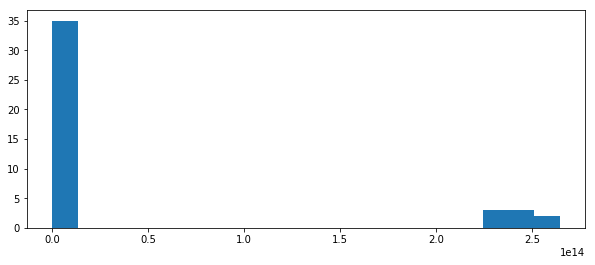

In [121]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[df['target']== 0].rmse.values, bins=20)

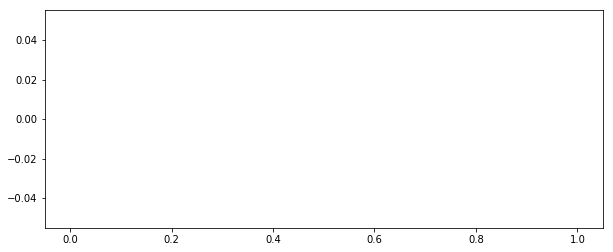

In [122]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[(df['target']== 0) & (df['rmse'] < 10)].rmse.values, bins=20)

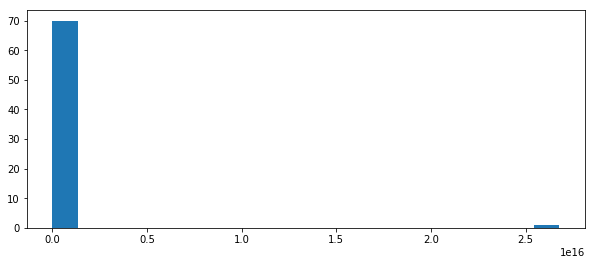

In [123]:

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[df['target'] > 0].rmse.values, bins=20)

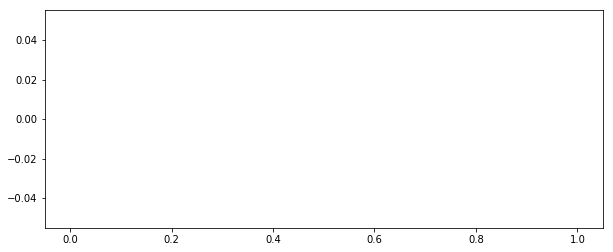

In [124]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[(df['target'] > 0) & (df['rmse'] < 10)].rmse.values, bins=20)

In [125]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_auc_score, 
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [126]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

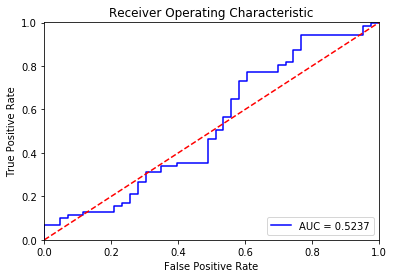

In [127]:

fpr, tpr, thresholds = roc_curve(df.target, df.rmse)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

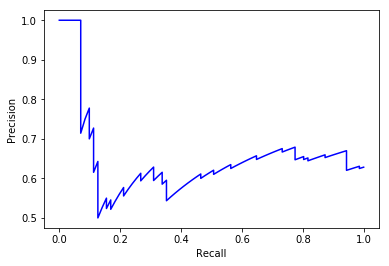

In [128]:
precision, recall, th = precision_recall_curve(df.target, df.rmse)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

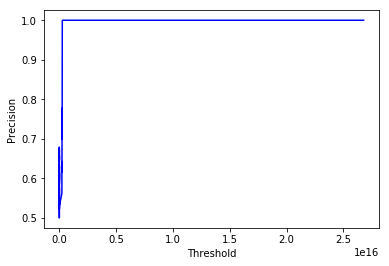

In [129]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Recall metric in the testing dataset:  1.0


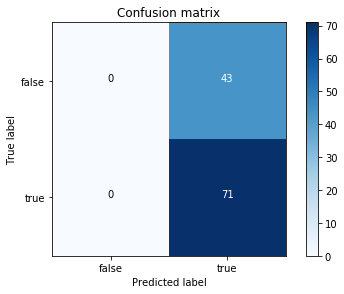

In [130]:
y_pred = [1 if p > 2 else 0 for p in df.rmse.values]
cnf_matrix = confusion_matrix(df.target, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = ['false','true']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [131]:
f1_score(y_pred=y_pred, y_true = df.target)

0.7675675675675676

In [132]:
precision_recall_fscore_support(y_pred=y_pred, y_true=df.target)

(array([0.  , 0.62]),
 array([0., 1.]),
 array([0.  , 0.77]),
 array([43, 71], dtype=int64))

In [133]:
from sklearn.metrics import accuracy_score

In [134]:
accuracy_score(df.target, y_pred)

0.6228070175438597

In [135]:
from sklearn.metrics import precision_score

In [136]:
precision_score(df.target, y_pred)

0.6228070175438597

In [137]:
from sklearn.metrics import recall_score

In [138]:
recall_score(df.target, y_pred)

1.0

In [65]:
#FOR PREPROCESSED DATASET

In [66]:
import numpy as np 
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
data = pd.read_csv("file4.csv")
data.head()

,Unnamed: 0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,target
0,0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,0
1,1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,0
2,2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,0
3,3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,0
4,4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,0


Text(0, 0.5, 'Frequency')

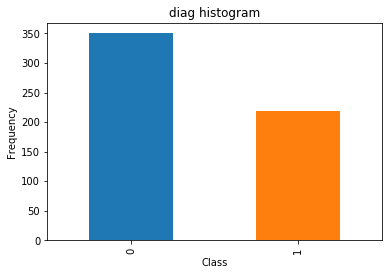

In [68]:
count_classes = pd.value_counts(data['target'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("diag histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [69]:
from sklearn.preprocessing import StandardScaler

In [70]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

#hour = data['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
#data['hour'] = StandardScaler().fit_transform(hour.reshape(-1, 1))

data = data.drop(['Time','Amount'],axis=1)
data.head()

KeyError: 'Amount'

In [71]:
class Autoencoder(object):

    def __init__(self, n_hidden_1, n_hidden_2, n_input, learning_rate):
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_input = n_input

        self.learning_rate = learning_rate

        self.weights, self.biases = self._initialize_weights()

        self.x = tf.placeholder("float", [None, self.n_input])

        self.encoder_op = self.encoder(self.x)
        self.decoder_op = self.decoder(self.encoder_op)

        self.cost = tf.reduce_mean(tf.pow(self.x - self.decoder_op, 2))
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.cost)

        init = tf.initialize_all_variables()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
      
        weights = {
            'encoder_h1': tf.Variable(tf.random_normal([self.n_input, self.n_hidden_1])),
            'encoder_h2': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_hidden_2])),
            'decoder_h1': tf.Variable(tf.random_normal([self.n_hidden_2, self.n_hidden_1])),
            'decoder_h2': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_input])),
        }
        biases = {
            'encoder_b1': tf.Variable(tf.random_normal([self.n_hidden_1])),
            'encoder_b2': tf.Variable(tf.random_normal([self.n_hidden_2])),
            'decoder_b1': tf.Variable(tf.random_normal([self.n_hidden_1])),
            'decoder_b2': tf.Variable(tf.random_normal([self.n_input])),
        }

        return weights, biases

    def encoder(self, X):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, self.weights['encoder_h1']),
                                       self.biases['encoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['encoder_h2']),
                                       self.biases['encoder_b2']))
        return layer_2

    def decoder(self, X):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, self.weights['decoder_h1']),
                                       self.biases['decoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['decoder_h2']),
                                       self.biases['decoder_b2']))
        return layer_2

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict={self.x: X})

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def transform(self, X):
        return self.sess.run(self.encoder_op, feed_dict={self.x: X})

    def reconstruct(self, X):
        return self.sess.run(self.decoder_op, feed_dict={self.x: X})

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
bad_data = data[data['target'] == 0]
good_data = data[data['target'] == 1]
#print 'bad: {}, good: {}'.format(len(bad_data), len(good_data))

In [74]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = X_train[X_train['target']==0]
X_train = X_train.drop(['target'], axis=1)

y_test = X_test['target']
X_test = X_test.drop(['target'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [75]:
X_good = good_data.ix[:, good_data.columns != 'target']
y_good = good_data.ix[:, good_data.columns == 'target']

X_bad = bad_data.ix[:, bad_data.columns != 'target']
y_bad = bad_data.ix[:, bad_data.columns == 'target']

C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Acer\Anaconda3\lib\

In [76]:
model = Autoencoder(n_hidden_1=15, n_hidden_2=3, n_input=X_train.shape[1], learning_rate = 0.01)

In [77]:
training_epochs = 100
batch_size = 256
display_step = 100
record_step = 10

In [78]:
total_batch = int(X_train.shape[0]/batch_size)

cost_summary = []

for epoch in range(training_epochs):
    cost = None
    for i in range(total_batch):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch = X_train[batch_start:batch_end, :]
        
        cost = model.partial_fit(batch)
    
    if epoch % display_step == 0 or epoch % record_step == 0:
        total_cost = model.calc_total_cost(X_train)
        
        if epoch % record_step == 0:
            cost_summary.append({'epoch': epoch+1, 'cost': total_cost})
        
        if epoch % display_step == 0:
            print("Epoch:{}, cost={:.9f}".format(epoch+1, total_cost))

Epoch:1, cost=3774.951660156


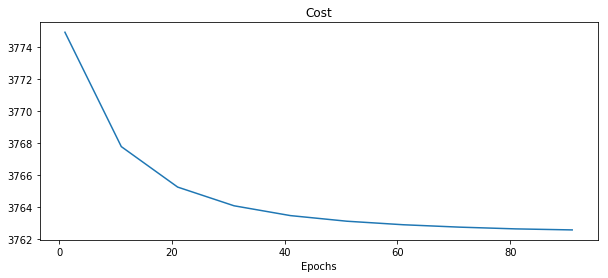

In [79]:
f, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(list(map(lambda x: x['epoch'], cost_summary)), list(map(lambda x: x['cost'], cost_summary)))
ax1.set_title('Cost')

plt.xlabel('Epochs')
plt.show()

In [80]:
encode_decode = None
total_batch = int(X_test.shape[0]/batch_size) + 1
for i in range(total_batch):
    batch_start = i * batch_size
    batch_end = (i + 1) * batch_size
    batch = X_test[batch_start:batch_end, :]
    batch_res = model.reconstruct(batch)
    if encode_decode is None:
        encode_decode = batch_res
    else:
        encode_decode = np.vstack((encode_decode, batch_res))

In [81]:
def get_df(orig, ed, _y):
    rmse = np.mean(np.power(orig - ed, 2), axis=1)
    return pd.DataFrame({'rmse': rmse, 'target': _y})

In [82]:
df = get_df(X_test, encode_decode, y_test)

In [83]:
df.describe()

,rmse,target
count,114.000000,114.000000
mean,10215.389631,0.385965
std,9779.607417,0.488972
min,2.963046,0.000000
25%,1542.942979,0.000000
50%,6486.833149,0.000000
75%,18579.362870,1.000000
max,29133.681315,1.000000


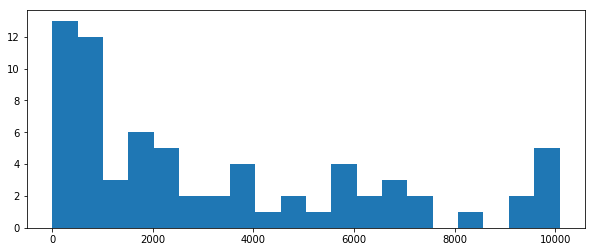

In [84]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[df['target']== 0].rmse.values, bins=20)

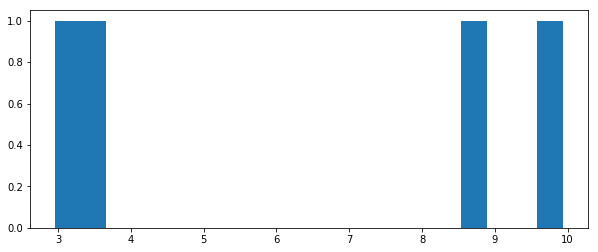

In [85]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[(df['target']== 0) & (df['rmse'] < 10)].rmse.values, bins=20)

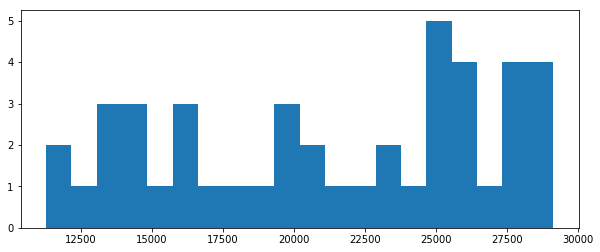

In [86]:

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[df['target'] > 0].rmse.values, bins=20)

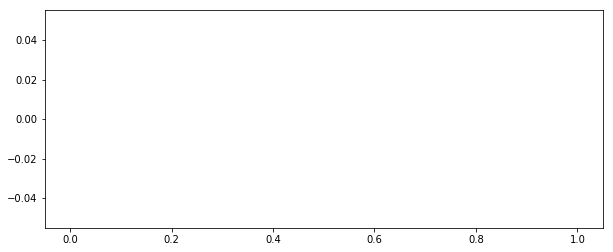

In [87]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[(df['target'] > 0) & (df['rmse'] < 10)].rmse.values, bins=20)

In [88]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_auc_score, 
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [89]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

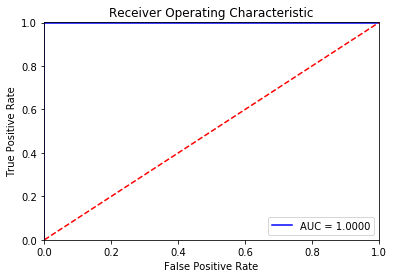

In [90]:
fpr, tpr, thresholds = roc_curve(df.target, df.rmse)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

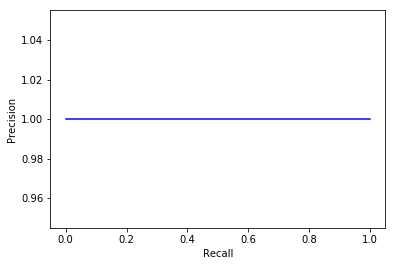

In [91]:
precision, recall, th = precision_recall_curve(df.target, df.rmse)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

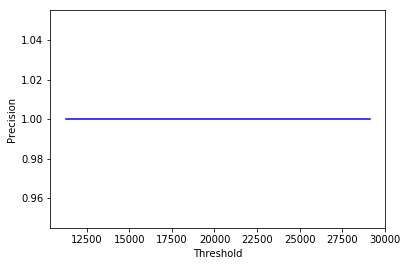

In [92]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Recall metric in the testing dataset:  1.0


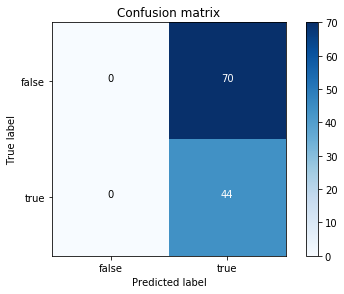

In [93]:
y_pred = [1 if p > 2 else 0 for p in df.rmse.values]
cnf_matrix = confusion_matrix(df.target, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = ['false','true']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [94]:
f1_score(y_pred=y_pred, y_true = df.target)

0.5569620253164557

In [95]:
precision_recall_fscore_support(y_pred=y_pred, y_true=df.target)

(array([0.  , 0.39]),
 array([0., 1.]),
 array([0.  , 0.56]),
 array([70, 44], dtype=int64))

In [96]:
from sklearn.metrics import accuracy_score

In [97]:
accuracy_score(df.target, y_pred)

0.38596491228070173

In [98]:
from sklearn.metrics import precision_score

In [99]:
precision_score(df.target, y_pred)

0.38596491228070173

In [100]:
from sklearn.metrics import recall_score

In [101]:
recall_score(df.target, y_pred)

1.0